### Why INCLINATION and SEMIMAJOR_AXIS
* Both require external force to change
* `SEMIMAJOR_AXIS` ignore variance in `APOAPSIS` and `PERIAPSIS`
* Both remains constant in an elliptical orbit
* Independent of each other
* `INCLINATION` remains fairly constant over long periods of time
* Note: `SEMIMAJOR_AXIS` decreases over time due to orbital decay.  In fact, a lot of maneuvers are orbit raising maneuvers to compensate for this.

### Problems encountered
* Data interval varies a lot - from 1 entry in 3 months to less than 2 hours between 2 TLEs
* Duplicates in data
* Some error in data (for example, random spikes)
* Due to different engine types, some maneuvers are quick (happens between 2 TLEs) and some takes place over a long time (2 weeks for some starlinks).
* The closeness of the satellite has a major and non-linear effect on its orbital decay rate
* Some satellites constantly maneuvers to stay in orbit (ie: starlink), some let it decay and does big boosts (ISS)
* It appears that `INCLINATION` suffers from periodic variance or just inaccuracies in measurement

In [1022]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [812]:
path = f'../../../siads591 data/payload_maneuver_pkl/all.pkl' # path to the data file
df = pd.read_pickle(path)

In [1103]:
satcat = pd.read_csv(f'../satcat_all.csv')

In [813]:
df = df.reset_index().sort_values(by=["NORAD_CAT_ID","EPOCH"]).drop_duplicates(subset=["NORAD_CAT_ID","EPOCH"]).set_index("EPOCH")

In [814]:
df.dtypes

INCLINATION       uint32
NORAD_CAT_ID      uint32
SEMIMAJOR_AXIS    uint32
dtype: object

In [1060]:
satellites = (44713, 25544, 16593, 39763, 17369,18187, 20580, 43078, 44495)
satellites_iterator = iter(satellites)
# 17369,18187 with strange readings
# humanity star 43168
# BLITS 35871
# iridium 33   24946
# cosmos 2251  22675
# terra 25994

In [1132]:
def remove_strange_data(input_df):
    # remove points that randomly spiked
    df = input_df.reset_index()
    s_diff_diff = (df.SEMIMAJOR_AXIS.diff()-df.SEMIMAJOR_AXIS.diff(-1)).abs()+1
    s_diff_sum = (df.SEMIMAJOR_AXIS.diff()+df.SEMIMAJOR_AXIS.diff(-1)).abs()
    i_diff_diff = (df.INCLINATION.diff()-df.INCLINATION.diff(-1)).abs()+1
    i_diff_sum = (df.INCLINATION.diff()+df.INCLINATION.diff(-1)).abs()
    # should return removed rows separately also
    return (df.loc[~(((s_diff_diff > 0) & (s_diff_sum / s_diff_diff > 1000)) | ((i_diff_diff > 0) & (i_diff_sum / i_diff_diff > 1000)))]).set_index("EPOCH")

def find_maneuvers(df, maneuver_functions):
    mdf = df.copy()
    all_ranges = []
    for col, name, func, thresholds in maneuver_functions:
        all_thresholds = []
        for threshold in thresholds:
            mdf['maneuvers'] = func(mdf[col])
            mdf['maneuvered'] = (mdf.maneuvers > threshold) | (mdf.maneuvers < -threshold)
            mdf['maneuvere_group'] = (mdf.maneuvered != mdf.maneuvered.shift())
            mdf['maneuvere_group'] = mdf['maneuvere_group'].fillna(False).astype(int).cumsum()
            grouped = mdf.reset_index().groupby('maneuvere_group')
            events = pd.DataFrame({'start' : grouped.EPOCH.first(),
                                   'end' : grouped.EPOCH.last(),
                                   'v' : grouped.maneuvered.first()}).reset_index(drop=True)
            events = events[events.v==True][['start','end']]
            day = pd.offsets.Day()
            events['start'] = events['start'] - day
            events['end'] = events['end'] + day
            events['group'] = (events.start >= events.end.shift()).cumsum()
            event_ranges = pd.DataFrame({'start' : events.groupby('group').start.first(),
                                         'end' : events.groupby('group').end.last()}).reset_index(drop=True)
            all_thresholds.append((threshold, event_ranges))
        
        all_ranges.append((col, name, mdf[["maneuvers"]], all_thresholds))
    return all_ranges
    
def plot_maneuvers(df, maneuver_results, sat_name):
    cmap = matplotlib.cm.get_cmap('GnBu')
    for col, name, maneuvers, thresholds_event_ranges in maneuver_results:
        fig, axes = plt.subplots(2, 1,figsize=(15,5))
        thresholds, event_ranges = zip(*thresholds_event_ranges)
        fig.suptitle(f'{sat_name}"{col} {name}" function w/ threshold: {thresholds}', fontsize=10)
        axes[0].set_title(col, fontsize=8)
        axes[1].set_title(f'"{col} {name}" w/ threshold {thresholds}', fontsize=8)

        axes[0].set_xlim(df.index[0], df.index[-1])
        axes[1].set_xlim(df.index[0], df.index[-1])
        axes[1].set_ylim(-1.5*max(thresholds), 1.5*max(thresholds))
        axes[0].get_xaxis().set_visible(False)
        
        df[col].plot(ax=axes[0], label="_", color="chocolate")
        maneuvers.dropna().plot(ax=axes[1], color="chocolate", label="_")
        xmin, xmax = axes[1].get_xlim()
        for i, threshold in enumerate(thresholds):
            axes[1].hlines([threshold, -threshold], xmin, xmax, color=cmap((i+1)/(len(thresholds)+2)), linewidth=1)
        
        for ax in axes:
            for i, event_range in enumerate(event_ranges):
                for _,er in event_range.iterrows():
                    ax.axvspan(er.start, er.end, alpha=1, color=cmap((i+1)/(len(thresholds)+2)), label="_")


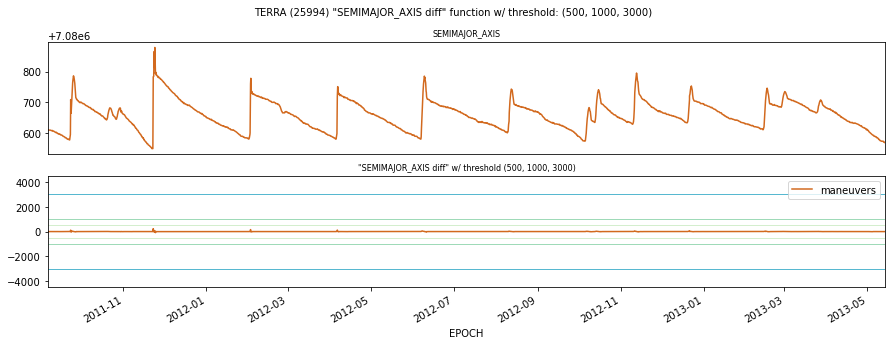

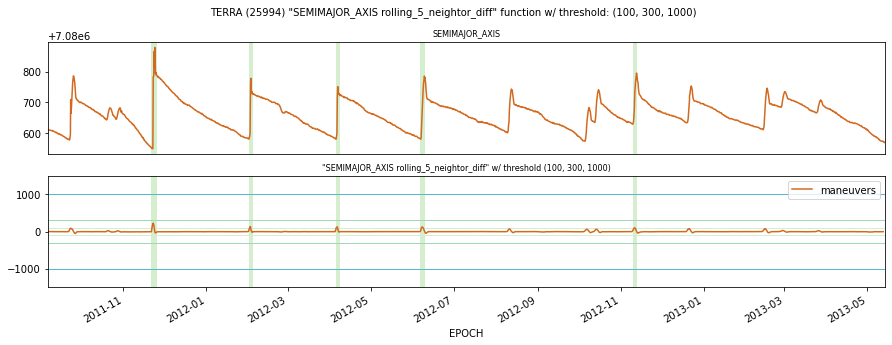

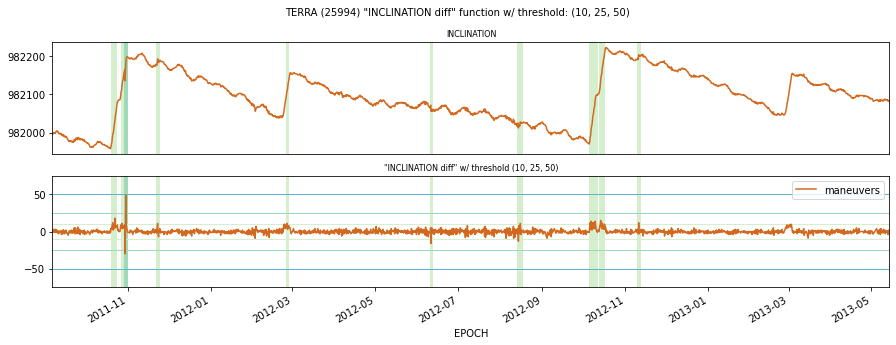

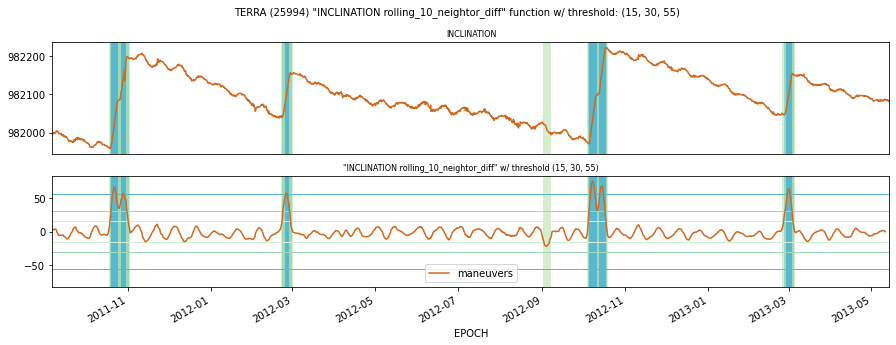

In [1138]:
maneuver_functions = [
    ("SEMIMAJOR_AXIS", "diff", lambda x:x - x.shift(), [500, 1000, 3000]),
#     ("SEMIMAJOR_AXIS", "neighbors_diff", lambda x:x.shift(-1) - x.shift(), [150, 400, 1000]),
#     ("SEMIMAJOR_AXIS", "rolling_3_neightor_diff", lambda x:x.rolling(3, min_periods=1).mean().shift(-2) - x.rolling(3, min_periods=1).mean(), [150, 400, 1000]),
    ("SEMIMAJOR_AXIS", "rolling_5_neightor_diff", lambda x:x.rolling(5, min_periods=1).mean().shift(-4) - x.rolling(5, min_periods=1).mean(), [100, 300, 1000]),
    ("INCLINATION", "diff", lambda x:x - x.shift(), [10,25,50]),
#     ("INCLINATION", "neighbors_diff", lambda x:x.shift(-1) - x.shift(), [10,25,50]),
#     ("INCLINATION", "rolling_4_neightor_diff", lambda x:x.rolling(4, min_periods=1).mean().shift(-3) - x.rolling(4, min_periods=1).mean(), [10,25,50]),
#     ("INCLINATION", "rolling_7_neightor_diff", lambda x:x.rolling(7, min_periods=1).mean().shift(-6) - x.rolling(7, min_periods=1).mean(), [15,30,55]),
    ("INCLINATION", "rolling_10_neightor_diff", lambda x:x.rolling(10, min_periods=1).mean().shift(-9) - x.rolling(10, min_periods=1).mean(), [15,30,55]),
#     ("INCLINATION", "rolling_20_neightor_diff", lambda x:x.rolling(20, min_periods=1).mean().shift(-19) - x.rolling(20, min_periods=1).mean(), [15,30,55]),
]

# implement a way to combine multple functions
# multi_maneuver_functions = [
#     ("SEMIMAJOR_AXIS", "rolling_5_neightor_diff", lambda x:x.rolling(5, min_periods=1).mean().shift(-4) - x.rolling(5, min_periods=1).mean(), 500),
#     ("INCLINATION", "rolling_10_neightor_diff", lambda x:x.rolling(10, min_periods=1).mean().shift(-9) - x.rolling(10, min_periods=1).mean(), 30),
# ]


norad_id = 25994
df_slice = slice(13500, 15500, None)
# norad_id = 44713
# df_slice = slice(None, None, None)
# norad_id = 25544
# df_slice = slice(-10000, -4000, None)

raw = df[df.NORAD_CAT_ID == norad_id][df_slice].copy()
raw["SEMIMAJOR_AXIS"] = raw["SEMIMAJOR_AXIS"].astype(pd.Int32Dtype())
raw["INCLINATION"] = raw["INCLINATION"].astype(pd.Int32Dtype())

fixed = remove_strange_data(raw)

maneuver_results = find_maneuvers(fixed, maneuver_functions)

stuff = (fixed, maneuver_results, f'{satcat.loc[(satcat.NORAD_CAT_ID == norad_id),"SATNAME"].values[0]} ({norad_id}) ')
plot_maneuvers(*stuff)

In [1134]:
len(raw)

23998

In [936]:
# # raw = df[df.NORAD_CAT_ID == 25544][16000:18000].copy()
# # raw = df[df.NORAD_CAT_ID == 25544].copy()
# # raw = df[df.NORAD_CAT_ID == next(satellites_iterator)].copy()
# # man = raw[['EPOCH']].copy()
# raw = df[df.NORAD_CAT_ID == 25544][200:].copy()

# raw["SEMIMAJOR_AXIS"] = raw["SEMIMAJOR_AXIS"].astype(pd.Int32Dtype())
# raw["INCLINATION"] = raw["INCLINATION"].astype(pd.Int32Dtype())
# # remove points that randomly spiked
# s_diff_diff = (raw.SEMIMAJOR_AXIS.diff()-raw.SEMIMAJOR_AXIS.diff(-1)).abs()
# s_diff_sum = (raw.SEMIMAJOR_AXIS.diff()+raw.SEMIMAJOR_AXIS.diff(-1)).abs()
# i_diff_diff = (raw.INCLINATION.diff()-raw.INCLINATION.diff(-1)).abs()
# i_diff_sum = (raw.INCLINATION.diff()+raw.INCLINATION.diff(-1)).abs()
# man = raw.loc[~(((s_diff_diff > 0) & (s_diff_sum / s_diff_diff > 1000)) | ((i_diff_diff > 0) & (i_diff_sum / i_diff_diff > 1000)))][['EPOCH','SEMIMAJOR_AXIS','INCLINATION']].copy()
# raw = raw.loc[~(((s_diff_diff > 0) & (s_diff_sum / s_diff_diff > 1000)) | ((i_diff_diff > 0) & (i_diff_sum / i_diff_diff > 1000)))][['EPOCH','SEMIMAJOR_AXIS','INCLINATION']].copy()

# # display(raw.loc[~(((s_diff_diff > 0) & (s_diff_sum / s_diff_diff > 1000)) | ((i_diff_diff > 0) & (i_diff_sum / i_diff_diff > 1000)))])

# # man["t_diff"] = man.EPOCH.diff()
# # df2 = df2[df2.t_diff > np.timedelta64(6,'h')].copy()

# # man["s_diff"] = man.SEMIMAJOR_AXIS - man.SEMIMAJOR_AXIS.shift()
# man["s_diff"] = man.SEMIMAJOR_AXIS - man.SEMIMAJOR_AXIS.shift()

# man["i_diff"] = man.INCLINATION - man.INCLINATION.shift()
# man["s_diff2"] = man.SEMIMAJOR_AXIS.shift(-1) - man.SEMIMAJOR_AXIS.shift()
# man["i_diff2"] = man.INCLINATION.shift(-1) - man.INCLINATION.shift()
# man["s_diff3"] = man.SEMIMAJOR_AXIS.rolling(3).mean().shift(-2) - man.SEMIMAJOR_AXIS.rolling(3).mean()
# man["i_diff3"] = man.INCLINATION.rolling(3).mean().shift(-2) - man.INCLINATION.rolling(3).mean()
# man["s_diff4"] = man.SEMIMAJOR_AXIS.rolling(4).mean().shift(-3) - man.SEMIMAJOR_AXIS.rolling(4).mean()
# man["i_diff4"] = man.INCLINATION.rolling(4).mean().shift(-3) - man.INCLINATION.rolling(4).mean()
# man["s_diff5"] = man.SEMIMAJOR_AXIS.rolling(5).mean().shift(-4) - man.SEMIMAJOR_AXIS.rolling(5).mean()
# man["i_diff5"] = man.INCLINATION.rolling(5).mean().shift(-4) - man.INCLINATION.rolling(5).mean()


# # normalize to 1 day if > 1 day
# # the numbers won't make much sense if you do a direct comparison, but used as a threshold it works
# # long_updates = (man.t_diff > np.timedelta64(1,'D'))
# # df2.loc[long_updates,"s_diff"] = df2.s_diff // (df2.t_diff / np.timedelta64(1,'D'))
# # df2.loc[long_updates,"i_diff"] = df2.i_diff // (df2.t_diff / np.timedelta64(1,'D'))
# # don't really need the time diff anymore
# # df2.drop(columns=["t_diff"], inplace=True)
# # convert the *_diff to int because those are fake precision anyways
# man["s_diff"] = man["s_diff"].astype(pd.Int32Dtype())
# man["i_diff"] = man["i_diff"].astype(pd.Int32Dtype())
# man["s_diff2"] = man["s_diff2"].astype(pd.Int32Dtype())
# man["i_diff2"] = man["i_diff2"].astype(pd.Int32Dtype())

# man["s_maneuvered"] = (man["s_diff5"] > 500) | (man["s_diff5"] < -500)
# man["i_maneuvered"] = (man["i_diff5"] > 20) | (man["i_diff5"] < -20)
# man["maneuvered"] = man["s_maneuvered"] | man["i_maneuvered"]
# # man["maneuvered"] = man["s_maneuvered"]

# # df2 = df2.dropna()

# man['maneuvere_group'] = (man.maneuvered != man.maneuvered.shift())
# man['maneuvere_group'] = man['maneuvere_group'].fillna(False).astype(int).cumsum()

# man = man.dropna()

# events = pd.DataFrame({'start' : man.groupby('maneuvere_group').EPOCH.first(),
#                        'end' : man.groupby('maneuvere_group').EPOCH.last(),
#                        'v' : man.groupby('maneuvere_group').maneuvered.first()}).reset_index(drop=True)
# events = events[events.v==True][['start','end']]
# day = pd.offsets.Day()
# events['start'] = events['start'] - day
# events['end'] = events['end'] + day
# events['group'] = (events.start >= events.end.shift()).cumsum()
# event_ranges = pd.DataFrame({'start' : events.groupby('group').start.first(),
#                              'end' : events.groupby('group').end.last()}).reset_index(drop=True)

# raw = raw.set_index("EPOCH")

In [937]:
# axes = raw[['SEMIMAJOR_AXIS','INCLINATION']].plot(subplots=True,figsize=(100,15))
# for ax in axes:
#     for _,er in event_ranges.iterrows():
#         ax.axvspan(er.start, er.end, alpha=0.2, color='green')

In [938]:
# axes = man.set_index("EPOCH")[['s_diff','s_diff2','s_diff3','s_diff4','s_diff5','i_diff','i_diff2','i_diff3','i_diff4','i_diff5']].plot(subplots=True,figsize=(10,30))
# for ax in axes:
#     for _,er in event_ranges.iterrows():
#         ax.axvspan(er.start, er.end, alpha=0.2, color='green')

In [668]:
# satellites = (44713, 25544, 16593, 39763, 17369,18187, 20580, 43078, 44495)
# satellites_iterator = iter(satellites)

In [939]:
# norad_id = next(satellites_iterator)
# sat = df[df.NORAD_CAT_ID==norad_id].copy()
# sat['I_ROLLING'] = sat.INCLINATION.rolling(5, center=True).median() # remove outliers
# sat['I_ROLLING_DIFF'] = sat.I_ROLLING.diff()
# sat['S_ROLLING'] = sat.SEMIMAJOR_AXIS.rolling(5, center=True).median() # remove outliers
# sat['S_ROLLING_DIFF'] = sat.S_ROLLING.diff()
# i_std = sat['I_ROLLING_DIFF'].std()*2
# s_std = sat['S_ROLLING_DIFF'].std()*2
# sat['EVENTS'] = (~sat.I_ROLLING_DIFF.between(-i_std,i_std)) | (~sat.S_ROLLING_DIFF.between(-s_std,s_std))
# sat['GROUPCHECK'] = (sat.EVENTS != sat.EVENTS.shift()).cumsum()
# sat = sat.dropna().reset_index()
# events = pd.DataFrame({'start' : sat.groupby('GROUPCHECK').EPOCH.first(),
#                        'end' : sat.groupby('GROUPCHECK').EPOCH.last(),
#                        'v' : sat.groupby('GROUPCHECK').EVENTS.first()}).reset_index(drop=True)
# events = events[events.v==True][['start','end']]
# day = pd.offsets.Day()
# events['start'] = events['start'] - day
# events['end'] = events['end'] + day
# events['GROUPCHECK'] = (events.start >= events.end.shift()).cumsum()
# event_ranges = pd.DataFrame({'start' : events.groupby('GROUPCHECK').start.first(),
#                              'end' : events.groupby('GROUPCHECK').end.last()}).reset_index(drop=True)
# sat = sat.set_index("EPOCH")
# axes = sat[['SEMIMAJOR_AXIS','INCLINATION']].plot(subplots=True,figsize=(10,8))
# for ax in axes:
#     for _,er in event_ranges.iterrows():
#         ax.axvspan(er.start, er.end, alpha=0.2, color='green')